In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Create the environment
def create_env():
    return gym.make('FrozenLake-v1', is_slippery=False)  # or True, depending on your use case

# Initialize Q-table
def initialize_q_table(env):
    number_of_states = env.observation_space.n #16, campo 4x4
    number_of_actions = env.action_space.n #4, su,giu,dx,sx
    return np.zeros((number_of_states, number_of_actions))

# Decay function for epsilon
def decay_function(episode, total_train_episodes, min_epsilon=0.01):
    return max(min_epsilon, min(1.0, 1.0 - np.log10((episode + 1) / (total_train_episodes * 0.1))))

# Choose action based on epsilon-greedy policy (Behavior Policy)
def choose_action(q_table, state, epsilon, env):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(q_table[state])  # Exploitation

# Generate an episode
def generate_episode(epsilon, q_table, env, max_env_steps):
    state = env.reset()
    total_reward = 0
    done = False
    trajectory = []
    
    for step in range(max_env_steps):
        if isinstance(state, tuple):
            state = state[0]

        action = choose_action(q_table, state, epsilon, env)
        new_state, reward, done, info, _ = env.step(action)
        trajectory.append((state, action, reward))
        state = new_state
        total_reward += reward
        if done:
            break
    
    return trajectory, total_reward

# Off-Policy Monte Carlo with Importance Sampling
def every_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    c_table = np.zeros_like(q_table)  # C table for accumulating weights
    rewards = []
    
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon)
        trajectory, total_reward = generate_episode(epsilon, q_table, env, max_env_steps)
        g = 0
        w = 1  # Initial weight
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
           
            avg_reward = total_reward / len(trajectory)
            
            g = gamma * g + avg_reward
            print(f"State: {state}, Action: {action}, Reward: {g}")
            c_table[state, action] += w
            q_table[state, action] += (w / c_table[state, action]) * (g - q_table[state, action])
            #print(q_table)
            gamma = gamma * 0.99
            
            # If the action taken is not the one that would have been taken by the greedy policy, break
            if action != np.argmax(q_table[state]):
                break
            
            w *= 1.0 / (epsilon / env.action_space.n)  # Update weight
        
        if episode % 100 == 0:
            rewards.append(total_reward)
            print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    
    rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, rewards


# First-Visit Monte Carlo with Off-Policy Control
def first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    returns_count = np.zeros_like(q_table)  # Counter for returns
    rewards = []
    

    # Inizializza un array 3D per memorizzare i valori di ciascuna cella per ogni episodio
    history = np.zeros((total_train_episodes, *q_table.shape))

    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon)
        trajectory, total_reward = generate_episode(epsilon, q_table, env, max_env_steps)
        g = 0
        
        first_visit_check = set()  # Set to check first visit
        
        for t in reversed(range(len(trajectory))):
            print(t)
            state, action, reward = trajectory[t]
            avg_reward = total_reward / len(trajectory)
            g = gamma * g + avg_reward
            print(f"State: {state}, Action: {action}, Reward: {g}")
            gamma = gamma * 0.99
            # First visit check
            if (state, action) not in first_visit_check:
                first_visit_check.add((state, action))
                returns_count[state, action] += 1
                q_table[state, action] += (1 / returns_count[state, action]) * (g - q_table[state, action])
                #print(q_table)
            
            # Se l'azione eseguita non è quella che sarebbe stata scelta dalla policy greedy, interrompi
            if action != np.argmax(q_table[state]):
                break

        # Memorizza lo stato della Q-table al termine dell'episodio
        history[episode] = q_table

        if episode % 100 == 0:
            rewards.append(total_reward)
            #print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")


    rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, rewards, history


# Plotting the training rewards
def plot_rewards(rewards, title, save_path):
    x = np.linspace(0, len(rewards) * 50, len(rewards))
    plt.plot(x, rewards, label='Monte Carlo')
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.savefig(save_path)
    plt.show()


    # Testing the policy with an epsilon-greedy approach
def test_policy_epsilon(env, q_table, num_episodes=10, epsilon=0.1):
    print(f"Testing the policy with epsilon = {epsilon}")
    rewards = []
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(num_episodes):
        state = env.reset()
        total_rewards = 0
        done = False
        
        for step in range(max_env_steps):
            if isinstance(state, tuple):
                state = state[0]
            
            # Use epsilon-greedy for testing
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # Exploration
            else:
                action = np.argmax(q_table[state])  # Exploitation

            state, reward, done, info, _ = env.step(action)
            total_rewards += reward
            env.render()
            if done:
                env.render()
                break
        
        rewards.append(total_rewards)
        print(f"Episode {episode}, reward {total_rewards}")
    
    print(f"Average score: {np.mean(rewards)}")


6
State: 1, Action: 1, Reward: 0.0
6
State: 1, Action: 1, Reward: 0.0
7
State: 1, Action: 1, Reward: 0.0
18
State: 1, Action: 1, Reward: 0.0
1
State: 1, Action: 1, Reward: 0.0
1
State: 4, Action: 2, Reward: 0.0
1
State: 1, Action: 1, Reward: 0.0
11
State: 1, Action: 1, Reward: 0.0
15
State: 1, Action: 1, Reward: 0.0
11
State: 1, Action: 1, Reward: 0.0
8
State: 9, Action: 3, Reward: 0.0
3
State: 4, Action: 2, Reward: 0.0
12
State: 13, Action: 0, Reward: 0.0
11
State: 14, Action: 0, Reward: 0.0
10
State: 10, Action: 1, Reward: 0.0
19
State: 6, Action: 0, Reward: 0.0
18
State: 2, Action: 1, Reward: 0.0
2
State: 8, Action: 1, Reward: 0.0
1
State: 1, Action: 1, Reward: 0.0
3
State: 4, Action: 2, Reward: 0.0
7
State: 8, Action: 1, Reward: 0.0
14
State: 4, Action: 2, Reward: 0.0
1
State: 4, Action: 2, Reward: 0.0
9
State: 1, Action: 1, Reward: 0.0
7
State: 1, Action: 1, Reward: 0.0
8
State: 3, Action: 1, Reward: 0.0
2
State: 1, Action: 1, Reward: 0.0
2
State: 1, Action: 1, Reward: 0.0
4
State

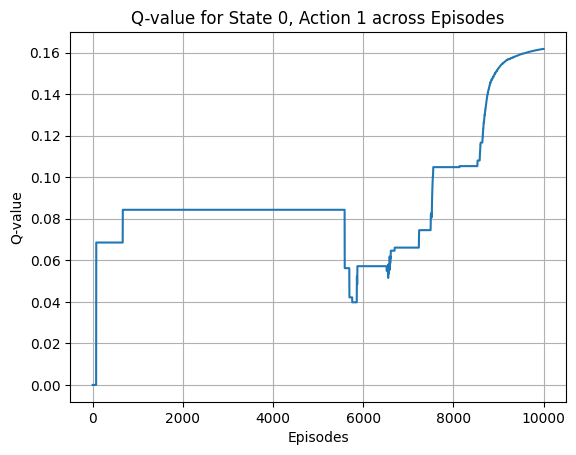

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Main code
if __name__ == "__main__":
    n_times = 1 #10 is slippery true, 5 otherwise
    total_train_episodes = 1000 #50000 if is slippery true
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01

    env = create_env()

    MC_tables = []
    MC_rewards = []

    for number in range(n_times):
        #print(f"\n ********** Training number {number}")
        q_table, rewards, history = first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        
    np.save('OFF/imgs/FV_MC_tables.npy', history)
    np.save('OFF/models/FV_MC_Q.npy', q_table)


    


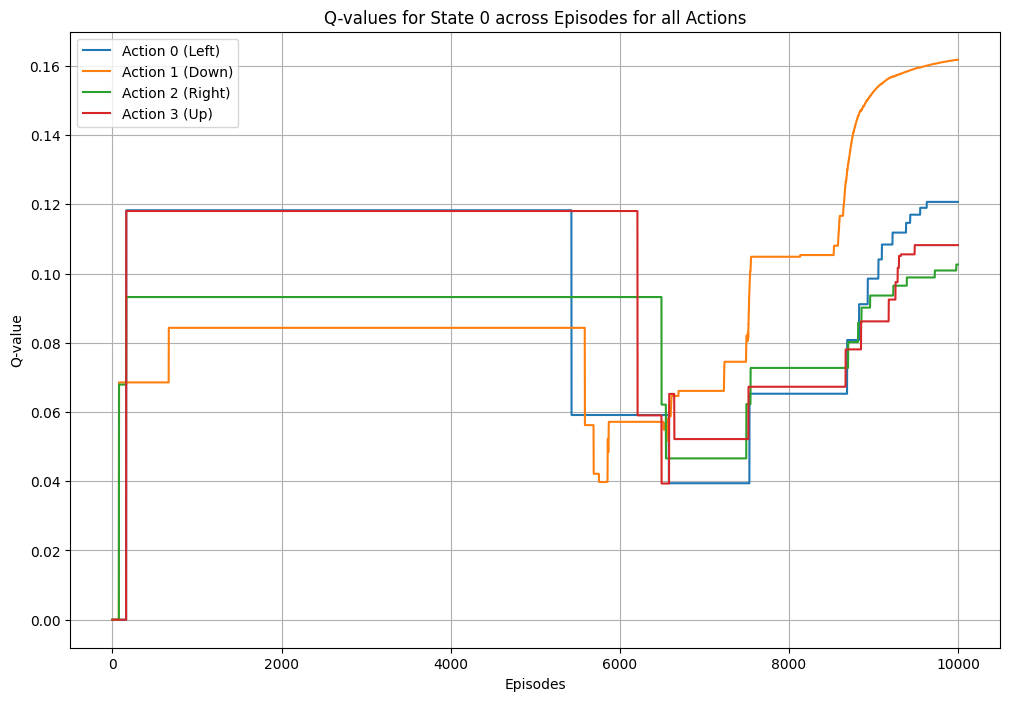

In [17]:

# Load the history of Q-tables across episodes
history = np.load('OFF/imgs/FV_MC_tables.npy')

# Select the state you want to plot
state = 0  # Example: state 0

# Number of actions (assuming 4 actions as in FrozenLake)
num_actions = history.shape[2]
action_labels = {
    0: 'Left',
    1: 'Down',
    2: 'Right',
    3: 'Up'
}


# Plot the values for all actions
plt.figure(figsize=(12, 8))
for action in range(num_actions):
    # Extract the values of the selected cell (state, action) from each episode
    q_values = history[:, state, action]
    plt.plot(q_values, label=f'Action {action} ({action_labels[action]})')

plt.title(f"Q-values for State {state} across Episodes for all Actions")
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Main code
if __name__ == "__main__":
    # Caso is slippery=True -> 10, 5 a false
    n_times = 5
    # Caso is slippery=True -> 50000, 10000 a false
    total_train_episodes = 5000
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01

    env = create_env()

    MC_tables = []
    MC_rewards = []

    for number in range(n_times):
        print(f"\n ********** Training number {number}")
        q_table, rewards = every_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        MC_tables.append(q_table)
        MC_rewards.append(rewards)

    MC_mean = np.mean(np.array(MC_rewards), axis=0)
    MC_mean_tables = np.mean(np.array(MC_tables), axis=0)
    #np.save('OFF/imgs/EV_MC_mean.npy', MC_mean)
    #np.save('OFF/models/EV_MC_tables.npy', MC_mean_tables) 
    #np.save('OFF/imgs/EV_MC_IS_mean.npy', MC_mean)
    #np.save('OFF/models/EV_MC_IS_tables.npy', MC_mean_tables)
    np.save('OFF/imgs/FV_MC_mean.npy', MC_mean)
    np.save('OFF/models/FV_MC_tables.npy', MC_mean_tables) 
    #np.save('OFF/imgs/FV_MC_IS_mean.npy', MC_mean)
    #np.save('OFF/models/FV_MC_IS_tables.npy', MC_mean_tables)
    #print("Mean rewards: ", MC_mean_tables)

    #plot_rewards(MC_mean, "Off-Policy Monte Carlo EV", "OFF/imgs/EV_MC_mean.png") MISSING!!!!!!!!!!!!!!
    #plot_rewards(MC_mean, "Off-Policy Monte Carlo EV", "OFF/imgs/EV_MC_IS_mean.png")
    #plot_rewards(MC_mean, "Off-Policy Monte Carlo FV", "OFF/imgs/FV_MC_mean.png")
    #plot_rewards(MC_mean, "Off-Policy Monte Carlo FV", "OFF/imgs/FV_MC_IS_mean.png")

    # Load Q-tables and test
    #q_table = np.load('OFF/models/EV_MC_IS_tables.npy', allow_pickle=True)
    #q_table = np.load('OFF/models/EV_MC_tables.npy', allow_pickle=True)
    q_table = np.load('OFF/models/FV_MC_tables.npy', allow_pickle=True)
    #q_table = np.load('OFF/models/FV_MC_IS_tables.npy', allow_pickle=True)
    
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="human")
    
    test_policy_epsilon(env, q_table, num_episodes=1, epsilon=0.1)
    
    env.close()


# Policy Plot

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def plot_policy(q_table, grid_size=(4, 4), title='Policy', save_path=None):
    """
    Plots the policy learned by the Q-table on a grid using text labels for directions.

    Parameters:
        q_table (numpy.ndarray): The Q-table from which to derive the policy.
        grid_size (tuple): The size of the grid representing the environment (default is (4, 4)).
    """
    # Define direction labels
    direction_labels = {
        0: '←',  # left
        1: '↓',  # down
        2: '→',  # right
        3: '↑'   # up
    }

  
    policy = np.argmax(q_table, axis=1).reshape(grid_size)
    
    
    # Set up the grid
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size[1]))
    ax.set_yticks(np.arange(grid_size[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Create grid
    ax.grid(which='both', linestyle='-', linewidth=2)
    
    # Plot direction labels
    i=0
    j=0
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            action = policy[i, j]
            direction = direction_labels[action]
            #print("Cella:",i,j, "Azione", action, "Direzione", direction)
            ax.text(j + 0.5, grid_size[0] - i - 0.5, direction,
                    ha='center', va='center', fontsize=12, color='black')

    # Set the aspect of the plot to equal
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])
    #plt.savefig(save_path)
    plt.show()


# # Usage example:
# if __name__ == "__main__":
#     # Assuming you have already saved your Q-tables as 'MC_tables.npy'
#     #FV_q_table = np.load('OFF/models/FV_MC_tables.npy', allow_pickle=True)
#     #EV_q_table = np.load('OFF/models/EV_MC_tables.npy', allow_pickle=True)
#     #Prima erano FV_policy e EV_policy, poi abbiamo cambiato in FV_IS e EV_IS
#     #plot_policy(FV_q_table, title='FV Off Policy', save_path='OFF/imgs/FV_policy.png')
#     #plot_policy(EV_q_table, title='EV Policy', save_path='OFF/imgs/EV_policy.png')
#     #EV_q_table = np.load('OFF/models/EV_MC_IS_tables.npy', allow_pickle=True)
#     #EV_q_table = np.load('OFF/models/EV_MC_IS_tables.npy', allow_pickle=True)    
#     #plot_policy(EV_q_table, title='EV Off Policy', save_path='OFF/imgs/EV_MC_policy.png')
#     #plot_policy(EV_q_table, title='EV Off Policy', save_path='OFF/imgs/EV_MC_IS_policy.png')
    
#     #FV_q_table = np.load('OFF/models/FV_MC_tables.npy', allow_pickle=True)
#     FV_q_table = np.load('OFF/models/FV_MC_IS_tables.npy', allow_pickle=True)    
#     plot_policy(FV_q_table, title='FV Off Policy', save_path='OFF/imgs/FV_MC_IS_policy.png')
#     #plot_policy(FV_q_table, title='FV Off Policy', save_path='OFF/imgs/FV_MC_policy.png')
    


# Codice corretto

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Create the environment
def create_env():
    return gym.make('FrozenLake-v1', is_slippery=False)  # or True, depending on your use case

# Initialize Q-table
def initialize_q_table(env):
    number_of_states = env.observation_space.n #16, campo 4x4
    number_of_actions = env.action_space.n #4, su,giu,dx,sx
    return np.zeros((number_of_states, number_of_actions))

# Decay function for epsilon
def decay_function(episode, total_train_episodes, min_epsilon=0.01):
    return max(min_epsilon, min(1.0, 1.0 - np.log10((episode + 1) / (total_train_episodes * 0.1))))

# Choose action based on epsilon-greedy policy (Behavior Policy)
def choose_action(q_table, state, epsilon, env):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(q_table[state])  # Exploitation

# Generate an episode
def generate_episode(epsilon, q_table, env, max_env_steps):
    state = env.reset()
    total_reward = 0
    done = False
    trajectory = []
    
    for step in range(max_env_steps):
        if isinstance(state, tuple):
            state = state[0]

        action = choose_action(q_table, state, epsilon, env)
        new_state, reward, done, info, _ = env.step(action)
        trajectory.append((state, action, reward))
        state = new_state
        total_reward += reward
        if done:
            break
    
    return trajectory, total_reward

# Off-Policy Monte Carlo with Importance Sampling

def every_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    c_table = np.zeros_like(q_table)  # C table for accumulating weights
    rewards = []
    success_counter = 0
    differences = []
    
    max_env_steps = env.spec.max_episode_steps
    stop = False
    
    for episode in range(total_train_episodes):
        if not stop:
            epsilon = decay_function(episode, total_train_episodes, min_epsilon)
            trajectory, total_reward = generate_episode(epsilon, q_table, env, max_env_steps)
            g = 0
            w = 1  # Initial weight
            
            for t in reversed(range(len(trajectory))):
                state, action, reward = trajectory[t]
                if reward==1:
                    success_counter +=1
                g = gamma * g + reward
                c_table[state, action] += w
                q_table[state, action] += (w / c_table[state, action]) * (g - q_table[state, action])
                differences.append(q_table[9,1])
                
                # If the action taken is not the one that would have been taken by the greedy policy, break
                if action != np.argmax(q_table[state]):
                    break
                
                w *= 1.0 / (epsilon / env.action_space.n)  # Update weight
            
            if episode % 50 == 0:
                rewards.append(total_reward)
                print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
            if success_counter == 10:
                print(f"\n***** Convergence reached at episode {episode} *****\n")
                with open('PROVE/convergence_log.txt', 'a') as file:
                    file.write(f"Ex number: {number}: Convergence: {episode} Epsilon: {epsilon}\n")
                stop = True
            if episode==total_train_episodes-1:
                with open('PROVE/convergence_log.txt', 'a') as file:
                    file.write(f"Ex number: {number} Convergence: NO\n")
    
    #rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, rewards, differences


# First-Visit Monte Carlo with Off-Policy Control
def first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    returns_count = np.zeros_like(q_table)  # Counter for returns
    rewards = []
    success_counter=0
    stop = False
    differences = []

    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        if not stop:
            epsilon = decay_function(episode, total_train_episodes, min_epsilon)
            trajectory, total_reward = generate_episode(epsilon, q_table, env, max_env_steps)
            g = 0
            
            first_visit_check = set()  # Set to check first visit
            
            for t in reversed(range(len(trajectory))):
                state, action, reward = trajectory[t]
                if reward==1:
                    success_counter +=1
                g = gamma * g + reward
                
                # First visit check
                if (state, action) not in first_visit_check:
                    first_visit_check.add((state, action))
                    returns_count[state, action] += 1
                    q_table[state, action] += (1 / returns_count[state, action]) * (g - q_table[state, action])
                    differences.append(q_table[0,1])
                
                # Se l'azione eseguita non è quella che sarebbe stata scelta dalla policy greedy, interrompi
                if action != np.argmax(q_table[state]):
                    break
            
            if episode % 50 == 0:
                rewards.append(total_reward)
                print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
            if success_counter == 10:
                print(f"\n***** Convergence reached at episode {episode} *****\n")
                with open('final/off/first_visit/convergence_log.txt', 'a') as file:
                    file.write(f"Ex number: {number}: Convergence: {episode} Epsilon: {epsilon}\n")
                stop = True
            if episode==total_train_episodes-1:
                with open('final/off/first_visit/convergence_log.txt', 'a') as file:
                    file.write(f"Ex number: {number} Convergence: NO\n")
    
    #print(f"\nVarianza per ogni cella della Q-table:\n{varianza_per_cella}\n")
    #rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    #plot_heatmap(varianza_per_cella)
    #plot_matrix_colormap(varianza_per_cella)
    #plot_bar_chart(varianza_per_cella)
    #plot_surface(varianza_per_cella)
    return q_table, rewards, differences



# Plotting the training rewards
def plot_rewards(rewards, title, save_path):
    x = np.linspace(0, len(rewards) * 50, len(rewards))
    plt.plot(x, rewards, label='Monte Carlo')
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.savefig(save_path)
    plt.show()


    # Testing the policy with an epsilon-greedy approach
def test_policy_epsilon(env, q_table, num_episodes=10, epsilon=0.1):
    print(f"Testing the policy with epsilon = {epsilon}")
    rewards = []
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(num_episodes):
        state = env.reset()
        total_rewards = 0
        done = False
        
        for step in range(max_env_steps):
            if isinstance(state, tuple):
                state = state[0]
            
            # Use epsilon-greedy for testing
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # Exploration
            else:
                action = np.argmax(q_table[state])  # Exploitation

            state, reward, done, info, _ = env.step(action)
            total_rewards += reward
            env.render()
            if done:
                env.render()
                break
        
        rewards.append(total_rewards)
        print(f"Episode {episode}, reward {total_rewards}")
    
    print(f"Average score: {np.mean(rewards)}")


In [ ]:
# Main code
if __name__ == "__main__":
    n_times = 100 #10 is is slippery true, 5 altrimenti
    total_train_episodes = 1000 #50000 if is slippery true
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01

    env = create_env()

    MC_tables = []
    MC_rewards = []
    
    variances = []

    for number in range(1):
        print(f"\n ********** Training number {number}")
        #q_table, rewards = first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        # q_table, rewards = every_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        # q_table, rewards, differences = first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        q_table, rewards, differences = every_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        # q_table, rewards = Monte_Carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon,True)
        #print(f"\n\n*** DIFFERENCES ***\n\n + {differences}")
        MC_tables.append(q_table)
        MC_rewards.append(rewards)
        
    print(f"\n\n DIFFERENCE \n\n {differences}")
    
    # we perform the mean of the rewards and the Q-tables to reduce variance
    #MC_mean = np.mean(np.array(MC_rewards), axis=0)
    MC_mean_table = np.mean(np.array(MC_tables), axis=0)
    #save_path_rw = 'final/off/every_visit/imgs/results_MC_OFF_TAB_rw.png'  # Adding .npy to this path
    #save_path_mc = 'final/off/every_visit/models/table_MC_OFF_TAB.npy'
    save_path_rw = 'final/off/first_visit/imgs/results_MC_OFF_TAB_rw.png'  # Adding .npy to this path
    save_path_mc = 'final/off/first_visit/models/table_MC_OFF_TAB.npy'
    #np.save(save_path_rw, MC_mean)  # Save the mean rewards
    np.save(save_path_mc, MC_mean_table)  # Save the mean Q-table
    
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="human")
    q_table = np.load(save_path_mc, allow_pickle=True)
    test_policy_epsilon(env, q_table, num_episodes=1, epsilon=0.1)
    
    env.close()
 

In [ ]:
 def analyze_convergence_data(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    count_no_convergence = 0
    episodes = []
    epsilons = []

    for line in lines:
        if "Convergence: NO" in line:
            count_no_convergence += 1
        else:
            parts = line.split()
            try:
                # Trovare il numero di episodi
                convergence_index = parts.index('Convergence:') + 1
                episodes.append(int(parts[convergence_index]))

                # Trovare il valore di epsilon
                epsilon_index = parts.index('Epsilon:') + 1
                epsilons.append(float(parts[epsilon_index]))
            except ValueError:
                continue  # salta eventuali linee mal formattate

    total_convergence = len(lines) - count_no_convergence
    average_episodes = sum(episodes) / len(episodes) if episodes else 0
    average_epsilon = sum(epsilons) / len(epsilons) if epsilons else 0

    return {
        'Numero di volte in cui la convergenza è stata raggiunta': total_convergence,
        'Numero medio di episodi richiesti': average_episodes,
        'Valore medio di epsilon': average_epsilon
    }

# Nome del file da leggere
filename = 'final/off/every_visit/convergence_log.txt'
results = analyze_convergence_data(filename)
print("Numero di volte in cui la convergenza è stata raggiunta:", results['Numero di volte in cui la convergenza è stata raggiunta'])
print("Numero medio di episodi richiesti:", results['Numero medio di episodi richiesti'])
print("Valore medio di epsilon:", results['Valore medio di epsilon'])


In [ ]:
filename = 'final/off/first_visit/convergence_log.txt'
results = analyze_convergence_data(filename)
print("Numero di volte in cui la convergenza è stata raggiunta:", results['Numero di volte in cui la convergenza è stata raggiunta'])
print("Numero medio di episodi richiesti:", results['Numero medio di episodi richiesti'])
print("Valore medio di epsilon:", results['Valore medio di epsilon'])

In [ ]:
filename = 'final/on/every_visit/convergence_log.txt'
results = analyze_convergence_data(filename)
print("Numero di volte in cui la convergenza è stata raggiunta:", results['Numero di volte in cui la convergenza è stata raggiunta'])
print("Numero medio di episodi richiesti:", results['Numero medio di episodi richiesti'])
print("Valore medio di epsilon:", results['Valore medio di epsilon'])

In [ ]:
filename = 'final/on/first_visit/convergence_log.txt'
results = analyze_convergence_data(filename)
print("Numero di volte in cui la convergenza è stata raggiunta:", results['Numero di volte in cui la convergenza è stata raggiunta'])
print("Numero medio di episodi richiesti:", results['Numero medio di episodi richiesti'])
print("Valore medio di epsilon:", results['Valore medio di epsilon'])